<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Introduction

The Monty Hall Problem is something of a cultural phenomenon. The problem reveals that our intuition can often fail us on even simple problems. Many often struggle to understand the solution even after a thorough explanation, and an understanding of statistics is often needed. In this notebook, I hope to demonstrate the solution in a more practical and accessible way.

# Description of the Problem

The Monty Hall Problem has it's origin in the game show "Let's Make a Deal". A contestant would be asked to chose one of three doors behind which are two goats and a car. Once the contestant had made their choice, the host would open one of the doors to reveal a goat. The contestant would then be asked if they wanted to stay with their original choice or switch to the other unopened door.

When first presented the problem, an overwhelming amount of people believe that that its a 50/50 chance of winning the car between staying and switching. Even Paul Erdős (of the famous "Erdos Number") remained unconvinced until presented a computer simulation of the problem. Reading this was what inspired this short notebook.

# Demonstration

In [9]:
import random
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [10]:
def setting_up_the_doors():
    # decide the car door
    door_list = ["goat", "goat", "goat"]
    chosen_door = random.randint(0,2)
    door_list[chosen_door] = "car"
    return door_list   

In [11]:
def choose_a_door(door_list):
    chosen_door = random.randint(0,2)
    door_contains = door_list[chosen_door]

    return chosen_door

In [12]:
def reveal_goat(door_list, chosen_door):
    doors_with_goats = get_doors_with_goats(door_list)
    revealed_door = random.choice(doors_with_goats)
       
    if revealed_door == chosen_door:
        doors_with_goats.remove(revealed_door)
        revealed_door = doors_with_goats[0]
    
    return revealed_door

In [13]:
def get_doors_with_goats(door_list):
    doors_with_goats = [i for i, x in enumerate(door_list) if x == "goat"]
    return doors_with_goats

In [15]:
def switch(door_list, chosen_door, revealed_doors):
    door_numbers = [0,1,2]
    door_numbers.remove(chosen_door)
    door_numbers.remove(revealed_door)
    
    chosen_door = door_numbers[0]
    
    return chosen_door

In [16]:
def assess_win(door_list, chosen_door):
    win = 0
    if (door_list[chosen_door]=='car'):
        win = 1
        
    return win

## Game Setup

In [17]:
doors = setting_up_the_doors()
chosen_door = choose_a_door(doors)
print("Door No.{} was chosen".format(chosen_door+1))
revealed_door = reveal_goat(doors, chosen_door)
print("Door No.{} was revealed to have a goat".format(revealed_door+1))

Door No.3 was chosen
Door No.2 was revealed to have a goat


## Staying

In [18]:
print("You chose to stay with your choice")
if assess_win(doors, chosen_door) == 1:
    print("You win")
else:
    print ("you lose")

You chose to stay with your choice
You win


## Switching

In [19]:
print("You chose to switch your choice")
switch_choice = switch(doors, chosen_door, revealed_door)
if assess_win(doors, switch_choice) == 1:
    print("You win")
else:
    print ("you lose")

You chose to switch your choice
you lose


# Testing

Now let's show the solution by running many Monty Hall Problems

## Visualisation of Results

In [21]:
numbers_of_games = 100
stay_win = 0
switch_win = 0
win_list = []

for x in range(numbers_of_games):
    doors = setting_up_the_doors()
    chosen_door = choose_a_door(doors)
    revealed_door = reveal_goat(doors, chosen_door)
    
    if assess_win(doors, chosen_door) == 1:
        win_list.append(0)
    else:
        win_list.append(1)     

print("The results are staying: {}% and switching: {}%".format(round(win_list.count(0)/numbers_of_games*100), round(win_list.count(1)/numbers_of_games*100)))

The results are staying: 30% and switching: 70%


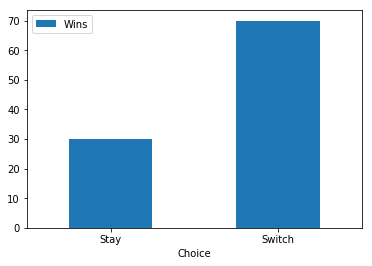

In [22]:
df = pd.DataFrame({'Choice':['Stay', 'Switch'], 'Wins':[win_list.count(0), win_list.count(1)]})
ax = df.plot.bar(x='Choice', y='Wins', rot=0)

# Machine Learning

## Creating a Dataset

In [126]:
dataset = pd.DataFrame(columns=['Chosen_Door', 'Revealed_Door', 'Action', 'Outcome'])

We will now run 500 games and randomly choose to stay or switch. We will record the data in a DataFrame.

In [127]:
numbers_of_games = 500

for x in range(numbers_of_games):
    action = False
    doors = setting_up_the_doors()
    chosen_door = choose_a_door(doors)
    revealed_door = reveal_goat(doors, chosen_door)
    
    chosen_action = random.randint(0,1)
    
    if chosen_action == 1:
        chosen_door = switch(doors, chosen_door, revealed_door)
        action = True
        
    if assess_win(doors, chosen_door) == 1:
        outcome = "win"
    else:
        outcome = "lose"  

    dataset = dataset.append({'Chosen_Door': chosen_door, 'Revealed_Door': revealed_door, 'Action': action, 'Outcome': outcome}, ignore_index=True)

dataset.head(10)

,Chosen_Door,Revealed_Door,Action,Outcome
0,0,2,False,win
1,2,0,False,win
2,2,0,True,lose
3,0,2,False,lose
4,1,2,True,lose
5,2,1,True,win
6,0,1,False,win
7,0,2,True,win
8,0,2,True,win
9,1,2,True,win


In [128]:
lose_percentage = dataset.groupby('Outcome').size()[0]/numbers_of_games*100
win_percentage = dataset.groupby('Outcome').size()[1]/numbers_of_games*100
print("Outcome 1: {}%".format(round(lose_percentage)))
print("Outcome 2: {}%".format(round(win_percentage)))

Outcome 1: 50.0%
Outcome 2: 50.0%


Looking at this there seems to be a problem. The true/false ratio seems closer to 50/50. This seemed strange until I considered the fact that the choice made after revealing the extra information is what skews the probability. It is analogous to a friend walking in after you have made a choice and the goat revealed. If you're friend does not know the reasoning behind the reveal and is asked to choose between to doors, the choice is 50/50.

Even though there are flaws in this dataset, I think there is some value in this dataset and we will continue to explore it further.

## Forming Models

In [129]:
array = dataset.values
X = array[:,0:3]
Y = array[:,3]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [130]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

In [131]:
results = []
names = []

for name, model in models: #name is included because of the 'NAME', in the model array
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.672500 (0.070223)
LDA: 0.672500 (0.070223)
KNN: 0.590000 (0.069101)
CART: 0.672500 (0.070223)
NB: 0.672500 (0.070223)
SVM: 0.672500 (0.070223)


We will continue using Naive Bayes to analyse this dataset.

## Analysing the Data

In [132]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
predictions = nb.predict(X_validation)

print(accuracy_score(Y_validation, predictions))

0.64


The models seems to be capped ~0.67, could this be related to the 2/3 probability inherent in the Monty Hall problem?

In [133]:
dataset_validation = pd.DataFrame(data=X_validation, columns=['Chosen_Door', 'Revealed_Door', 'Action'])
dataset_validation['Outcome'] = Y_validation
dataset_validation['Results'] = predictions
dataset_validation.head()

,Chosen_Door,Revealed_Door,Action,Outcome,Results
0,0,1,True,win,win
1,0,1,False,lose,lose
2,1,0,True,win,win
3,1,0,False,win,lose
4,0,1,True,lose,win


In [134]:
lose_percentage_validation = dataset_validation.groupby('Outcome').size()[0]/(numbers_of_games/5)*100
win_percentage_validation = dataset_validation.groupby('Outcome').size()[1]/(numbers_of_games/5)*100
print("Outcome 1: {}%".format(round(lose_percentage_validation)))
print("outcome 2: {}%".format(round(win_percentage_validation)))

Outcome 1: 50.0%
outcome 2: 50.0%


The validation set still still has ~50/50 wins and loses.

In [135]:
dataset_validation.loc[dataset_validation['Outcome'] != dataset_validation['Results']]

,Chosen_Door,Revealed_Door,Action,Outcome,Results
3,1,0,False,win,lose
4,0,1,True,lose,win
7,1,0,True,lose,win
17,2,0,False,win,lose
22,2,0,False,win,lose
24,2,0,True,lose,win
26,0,1,False,win,lose
33,1,2,True,lose,win
35,1,0,True,lose,win
37,1,2,True,lose,win


In [136]:
len(dataset_validation.loc[dataset_validation['Outcome'] != dataset_validation['Results']])

36

This seems to suggest that even though the switching was random, the model still picked up on the relationship between switching and results, let's look into this further.

In [149]:
dataset_validation.loc[(dataset_validation['Action'] == True) & (dataset_validation['Results'] == 'win')].head(10)

,Chosen_Door,Revealed_Door,Action,Outcome,Results
0,0,1,True,win,win
2,1,0,True,win,win
4,0,1,True,lose,win
7,1,0,True,lose,win
8,2,0,True,win,win
10,0,1,True,win,win
11,1,0,True,win,win
12,1,0,True,win,win
13,2,1,True,win,win
14,2,1,True,win,win


In [150]:
dataset_validation.loc[(dataset_validation['Action'] == False) & (dataset_validation['Results'] == 'lose')].head(10)

,Chosen_Door,Revealed_Door,Action,Outcome,Results
1,0,1,False,lose,lose
3,1,0,False,win,lose
5,0,2,False,lose,lose
6,1,0,False,lose,lose
9,0,2,False,lose,lose
15,1,0,False,lose,lose
16,1,2,False,lose,lose
17,2,0,False,win,lose
18,0,2,False,lose,lose
20,1,0,False,lose,lose


In [153]:
len(dataset_validation.loc[(dataset_validation['Action'] == True) & (dataset_validation['Results'] == 'win')]) + len(dataset_validation.loc[(dataset_validation['Action'] == False) & (dataset_validation['Results'] == 'lose')])

100

This is the same length as the total dataset, this suggests that the 'Action' feature has the strongest relationship to the results. Let's confirm this.

In [154]:
model = LogisticRegression()
rfe = RFE(model, 1)
fit = rfe.fit(X, Y)
print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)

Num Features:  1
Selected Features:  [False False  True]
Feature Ranking:  [3 2 1]


In [155]:
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X, Y)
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
print(features[0:5,:])

[ 0.097  0.073 26.471]
[[0. 2. 0.]
 [2. 0. 0.]
 [2. 0. 1.]
 [0. 2. 0.]
 [1. 2. 1.]]


This confirms that 'Outcome' has the strongest relation with the output variable by far, and the model picked up on this despite the random choice of whether to switch.